## Predicting Sales - Google Analytics

OBJ: Based on the client behavior in a certain website, predict sales on the website, using google Analytics


## Libraries

In [1]:

import pandas as pd
import numpy as np


# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#preparing data
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

#models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA 
from sklearn.preprocessing import Binarizer
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


#ANN
import tensorflow as tf
from tensorflow import keras

#metrics
from sklearn.metrics import roc_curve,auc, classification_report
from sklearn.metrics import confusion_matrix,precision_score, recall_score,f1_score
from sklearn.metrics import precision_recall_curve,roc_auc_score
from sklearn import metrics

from sklearn.model_selection import cross_val_score

## Functions

In [2]:
def relaciones_vs_target(X, Y, return_type='axes'):
    
    
    fig_tot = (len(X.columns))
    fig_por_fila = 4
    tamanio_fig = 4
    num_filas = int( np.ceil(fig_tot/fig_por_fila) )    
    plt.figure( figsize=( fig_por_fila*tamanio_fig+5, num_filas*tamanio_fig+5 ) )
    c = 0 
    for i, col in enumerate(X.columns):
        plt.subplot(num_filas, fig_por_fila, i+1)
        sns.scatterplot(x=X[col], y=Y)
        plt.title( '%s vs %s' % (col, 'target') )
        plt.ylabel('Target')
        plt.xlabel(col)
    plt.show()

def represento_doble_hist(x_1, x_0, n_bins=11, title='', label_1='Clase 1', 
                          label_0='Clase 0', density=0):
    
    bins = n_bins
    plt.hist(x_1, bins, density = density, alpha=0.5, label=label_1, color='red')    
    plt.hist(x_0, bins, density = density, alpha=0.5, label=label_0, color='green')
    plt.title(title)
    plt.legend(loc='best') 

def hist_pos_neg_feat(x, y, density=0, nbins=11, targets=(0,1)):
    
    fig_tot = len(x.columns)
    fig_tot_fila = 4; fig_tamanio = 4
    num_filas = int( np.ceil(fig_tot/fig_tot_fila) )
    plt.figure( figsize=( fig_tot_fila*fig_tamanio+2, num_filas*fig_tamanio+2 ) )
    target_neg, target_pos = targets
    for i, feat in enumerate(x.columns):
        plt.subplot(num_filas, fig_tot_fila, i+1);
        plt.title('%s' % feat)
        idx_pos = y == target_pos
        idx_neg= y == target_neg
        represento_doble_hist(x[feat][idx_pos].values, x[feat][idx_neg].values, nbins, 
                   density = density, title=('%s' % feat))

def plot_roc_curve(fpr, tpr,roc_auc,name_modelo, label=None):
       
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC-Curve-Modelo:{} '.format(name_modelo))
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.figure(figsize=(5, 4))
    plt.show()


def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
        
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    plt.figure(figsize=(8, 4))
    plt.show()

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.title('Precision-Recall Curve')
    plt.axis([0, 1, 0, 1])
    plt.figure(figsize=(8, 6))
    
    
def repre_matriz_confusion(matriz):
    
    
    df_matriz_confusion = pd.DataFrame(matriz,
                     ['True Normal','True Fraud'],
                     ['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    sns.set(font_scale=1.4)
    plt.title(u'Matriz de confusión')
    _ = sns.heatmap(df_matriz_confusion, annot=True, annot_kws={"size": 16}, fmt='g')
    
    
def reporting_modelo(y_reales, y_clase):
      
    matriz_confusion = metrics.confusion_matrix(y_reales, y_clase)
    roc_auc = metrics.roc_auc_score(y_reales, y_clase)
    metrica_f1 = metrics.f1_score(y_reales, y_clase)
    print(u'La AUC de la ROC es de: {}'.format(round(roc_auc,3)))
    print(u'La F1 es de: {}'.format(round(metrica_f1,2)))
    print("\nAccuracy\t{}".format(round(metrics.accuracy_score(y_reales, y_clase),3)))  
    print("Sensitividad\t{}".format(round(metrics.recall_score(y_reales, y_clase),3)))
    print(u"Precisión\t{}".format(round(metrics.precision_score(y_reales, y_clase),3)))   
    repre_matriz_confusion(matriz_confusion)   
    
def reporte_metricas(y_test,y_predict):
       
    print(classification_report(y_test,y_predict))
    print(' Precision: {}'.format(round(precision_score(y_test,y_predict),2)))
    print(' Recall/Sensibilidad: {}'.format(round(recall_score(y_test,y_predict),2)))
    print(' f1-Score: : {}'.format(round(f1_score(y_test,y_predict),2)))

    

## 1._Getting Data

In [3]:
XY=pd.read_csv('./Datos/online_shoppers_intention.csv',sep=',')


## 2._EDA

### 2.1. Description

In [4]:
XY.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12316 non-null  float64
 1   Administrative_Duration  12316 non-null  float64
 2   Informational            12316 non-null  float64
 3   Informational_Duration   12316 non-null  float64
 4   ProductRelated           12316 non-null  float64
 5   ProductRelated_Duration  12316 non-null  float64
 6   BounceRates              12316 non-null  float64
 7   ExitRates                12316 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [5]:
print('- Size (filas, col) del data set: {}'.format(XY.shape))
print ( '- categorical columns: {}'.format(XY.select_dtypes(include='object').columns))
print ( '- Bolean columns: {}'.format(XY.select_dtypes(include='bool').columns))
print ( '- Numeric columns: {}'.format(XY.select_dtypes(include='number').columns))


- Size (filas, col) del data set: (12330, 18)
- categorical columns: Index(['Month', 'VisitorType'], dtype='object')
- Bolean columns: Index(['Weekend', 'Revenue'], dtype='object')
- Numeric columns: Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType'],
      dtype='object')


* Deleting 'Browser' y 'Os/System' columns, as they wont be quite relevant

In [6]:
XY=XY.drop(columns=['OperatingSystems', 'Browser'],axis=1)

In [7]:
XY.head(4) 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,2,4,Returning_Visitor,False,False


In [8]:
XY.describe() 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,9.000000,20.000000


    - insight: Some variables have missing values. Posible data ="-1" coudl mean NaN/similar in certain columns such as Administratice Duration... To check with the sourcing/metadato to manage

In [9]:
# wieght of the data=-1 values
for i in ['Administrative_Duration', 'Informational_Duration','ProductRelated_Duration']:
    a=XY[XY[i]==-1].count()[i]
    print(i,a,'porcentaje:',round(100*a/len(XY[i]),2))


Administrative_Duration 33 porcentaje: 0.27
Informational_Duration 33 porcentaje: 0.27
ProductRelated_Duration 33 porcentaje: 0.27


* Low weight, so they wont influence the process. I continue modeling

* understanding category data:

In [10]:
XY.select_dtypes(include='object').nunique()

Month          10
VisitorType     3
dtype: int64

In [11]:
XY['Month'].unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [12]:
XY['VisitorType'].unique()

array(['Returning_Visitor', 'New_Visitor', 'Other'], dtype=object)

In [13]:
pd.crosstab(XY['VisitorType'],XY['Revenue'], margins=True) # wieght of the value  'Other' Vs. Revenue

Revenue,False,True,All
VisitorType,,,
New_Visitor,1272,422,1694
Other,69,16,85
Returning_Visitor,9081,1470,10551
All,10422,1908,12330


In [14]:
pd.crosstab(XY['VisitorType'],XY['Region'], margins=True)

Region,1,2,3,4,5,6,7,8,9,All
VisitorType,,,,,,,,,,
New_Visitor,657,149,312,139,50,121,100,74,92,1694
Other,8,5,8,5,0,1,2,1,55,85
Returning_Visitor,4115,982,2083,1038,268,683,659,359,364,10551
All,4780,1136,2403,1182,318,805,761,434,511,12330


insight: low weigth of VisitorType=Others, and very much associated to the Region=9. Could be interesteing during the final findings

### 2.2. Coding to numeric variables

    A. - CAtegory to Numeric

        1.- Variable 'Month'

In [15]:
XY.Month.unique()

array(['Feb', 'Mar', 'May', 'Oct', 'June', 'Jul', 'Aug', 'Nov', 'Sep',
       'Dec'], dtype=object)

In [16]:
dic=dict(zip(XY.Month.unique(),[2,3,5,10,6,7,8,11,9,12]))
XY.Month.replace(dic, inplace=True)

        2.- Variable 'VisitorType'- To pass to  {New_visitor:0. other:1,Returning_visitor:2} values

In [17]:
le=LabelEncoder()
XY['VisitorType']=le.fit_transform(XY['VisitorType'].values)

    B. -  Booleanas to numeric

In [18]:
XY.Revenue.unique() 

array([False,  True])

In [19]:
XY.Weekend.unique()

array([False,  True])

In [20]:
XY['Revenue']=XY['Revenue'].astype(int)
XY.Weekend=XY.Weekend.astype(int)

### 2.3.Missing values

 -  missing values

In [21]:
sum_na=XY.isnull().sum()
sum_na

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

- % de missing values

In [22]:
round(sum_na/len(XY),3)*100

Administrative             0.1
Administrative_Duration    0.1
Informational              0.1
Informational_Duration     0.1
ProductRelated             0.1
ProductRelated_Duration    0.1
BounceRates                0.1
ExitRates                  0.1
PageValues                 0.0
SpecialDay                 0.0
Month                      0.0
Region                     0.0
TrafficType                0.0
VisitorType                0.0
Weekend                    0.0
Revenue                    0.0
dtype: float64


- There are only a few NAN values. I delete them as they represent ony the 0.1%


In [23]:
XY=XY.dropna(axis=0, how='any') 

In [24]:
XY.isnull().sum()==0 

Administrative             True
Administrative_Duration    True
Informational              True
Informational_Duration     True
ProductRelated             True
ProductRelated_Duration    True
BounceRates                True
ExitRates                  True
PageValues                 True
SpecialDay                 True
Month                      True
Region                     True
TrafficType                True
VisitorType                True
Weekend                    True
Revenue                    True
dtype: bool


### 2.4- Defining  independientes (X)  and target (y) variables


In [25]:
X=XY.drop(columns='Revenue', axis=1)
y=XY['Revenue']

### 2.5. Visualization
* 2.5.1 Distribution Numeric variables

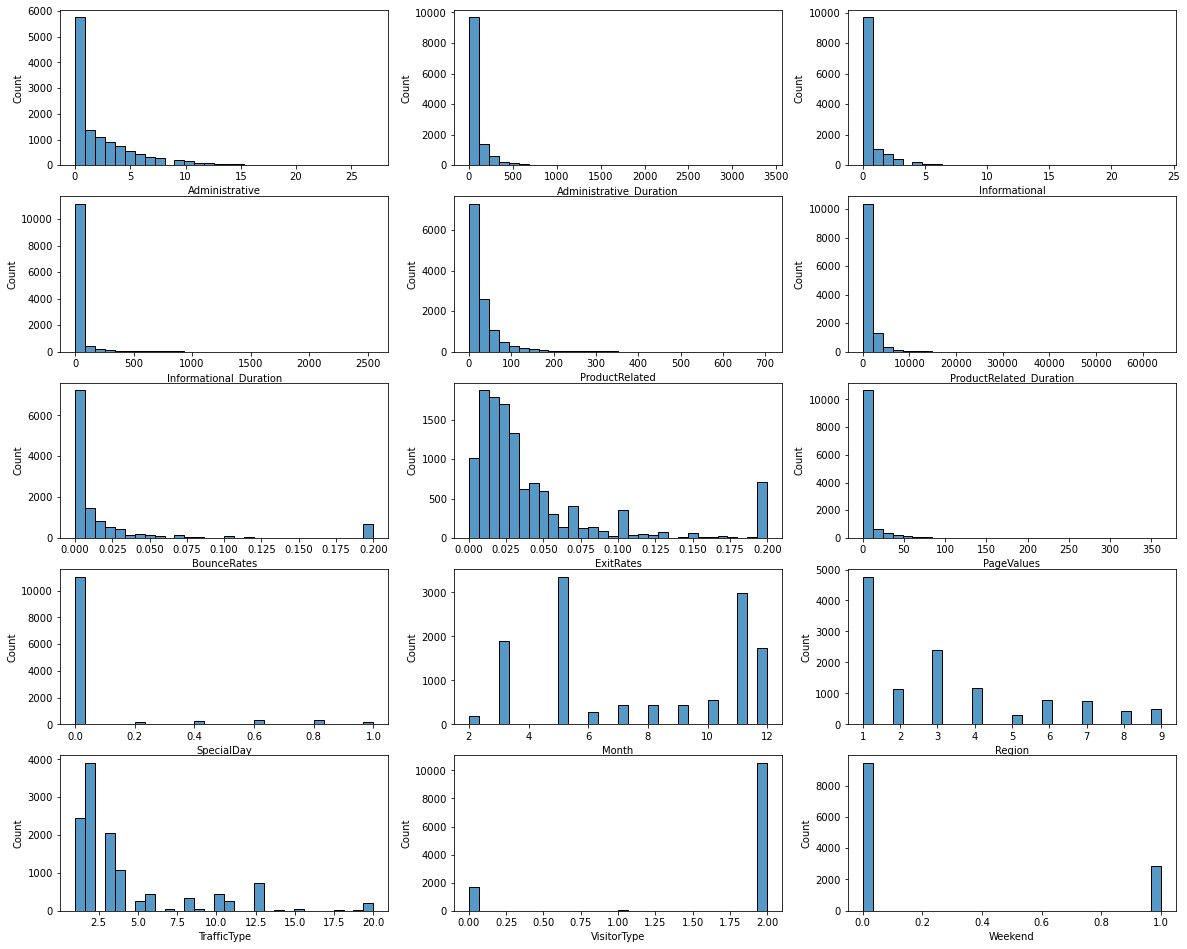

In [26]:
plt.figure(figsize=(20,20))
n = 0
for i, column in enumerate(X.columns):
    n+=1
    plt.subplot(6, 3, n)
    sns.histplot(X[column], bins=30)
    # plt.title('Dist {}'.format(column))
plt.show()

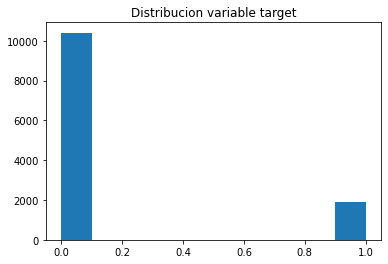

In [27]:
plt.hist(y)
plt.title('Distribucion variable target')
plt.show()

    insight: Important imbalance of the target variable

* 2.5.2. Outliers identification - numeric  variables

    * Standarizing

In [28]:
X_normalizado = (X-X.mean())/X.std()

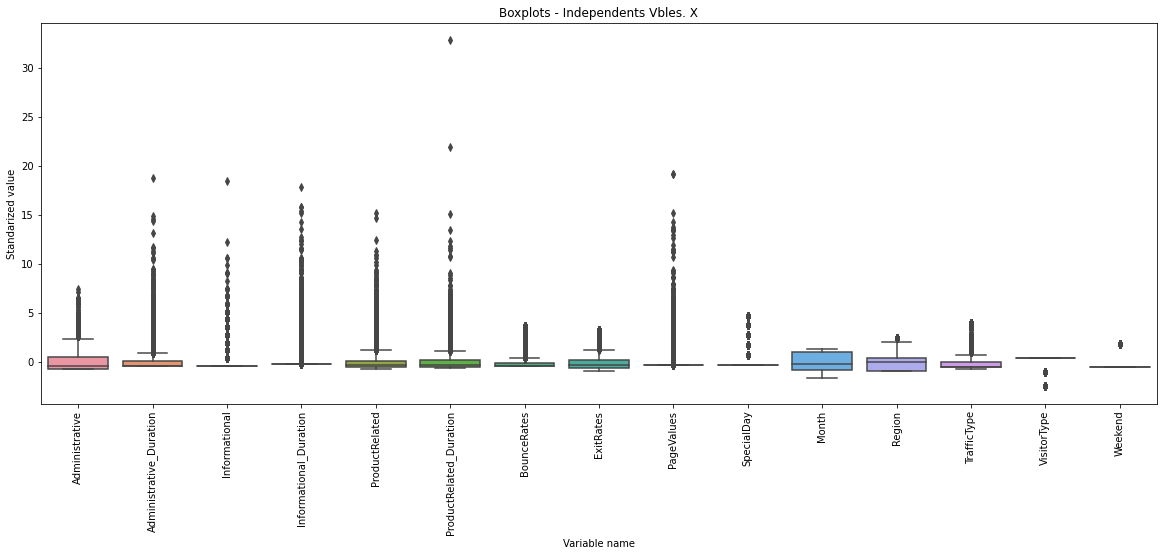

In [29]:
plt.figure(figsize=(20,7))
ax = sns.boxplot(data=X_normalizado)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title(u'Boxplots - Independents Vbles. X')
plt.ylabel('Standarized value')
_ = plt.xlabel('Variable name')

    * insight: important outliers quantity. A Scalarization will be needed.

### 2.6 Relation between X, y
#### 2.6.1 Distribution  X(i),y

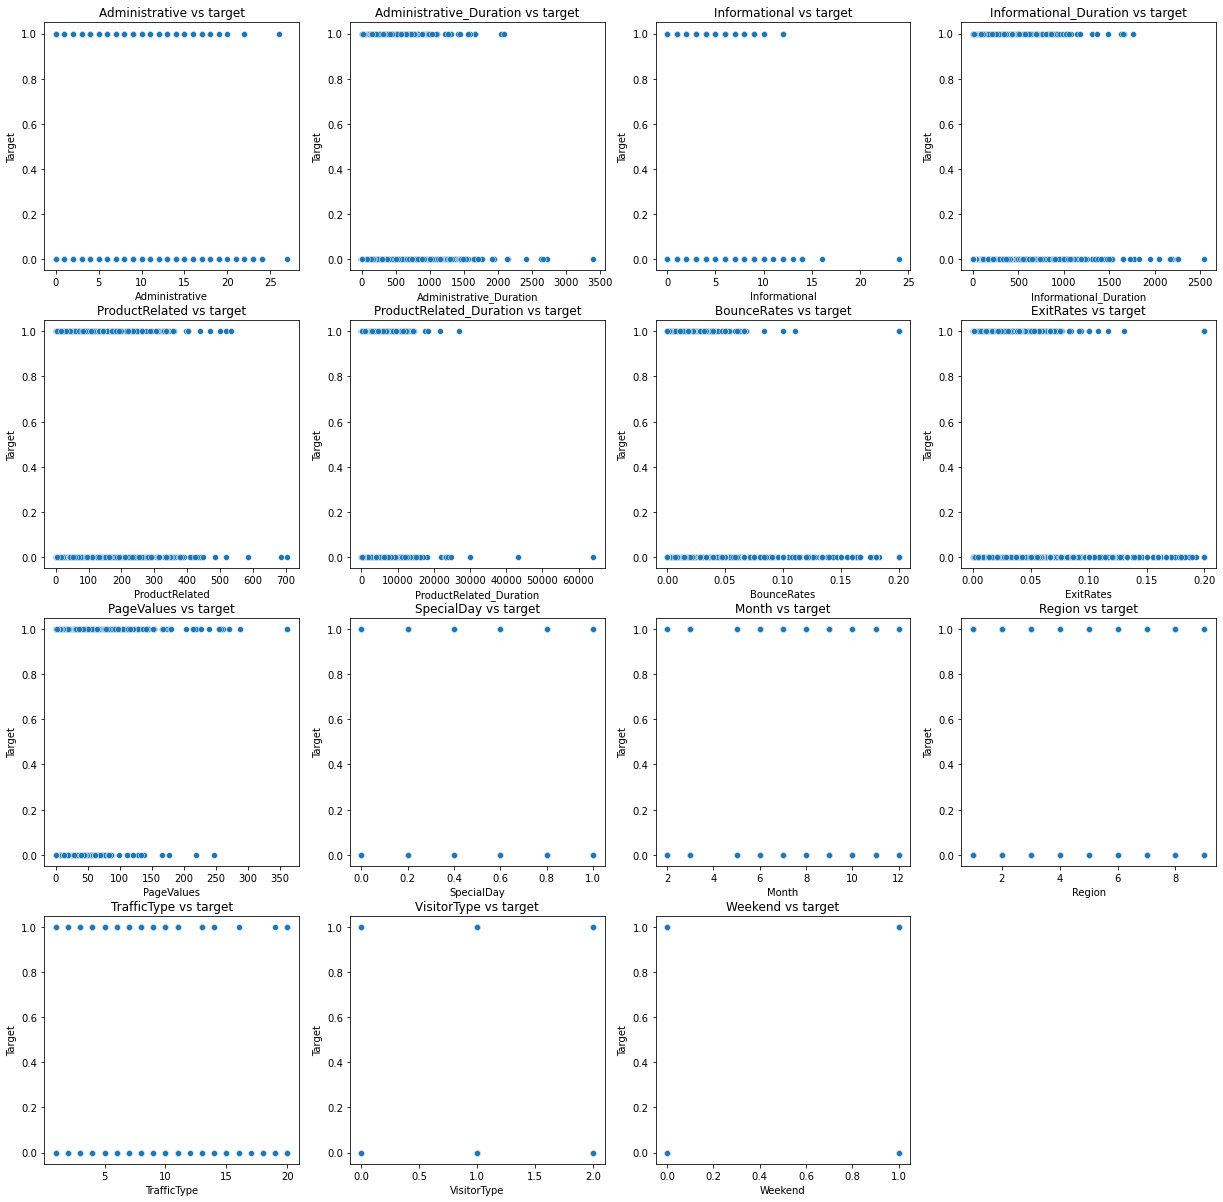

In [30]:
relaciones_vs_target(X, y)

* insights: variables such as ExitRate, BounceRate and PageValue could have different values depending of the target

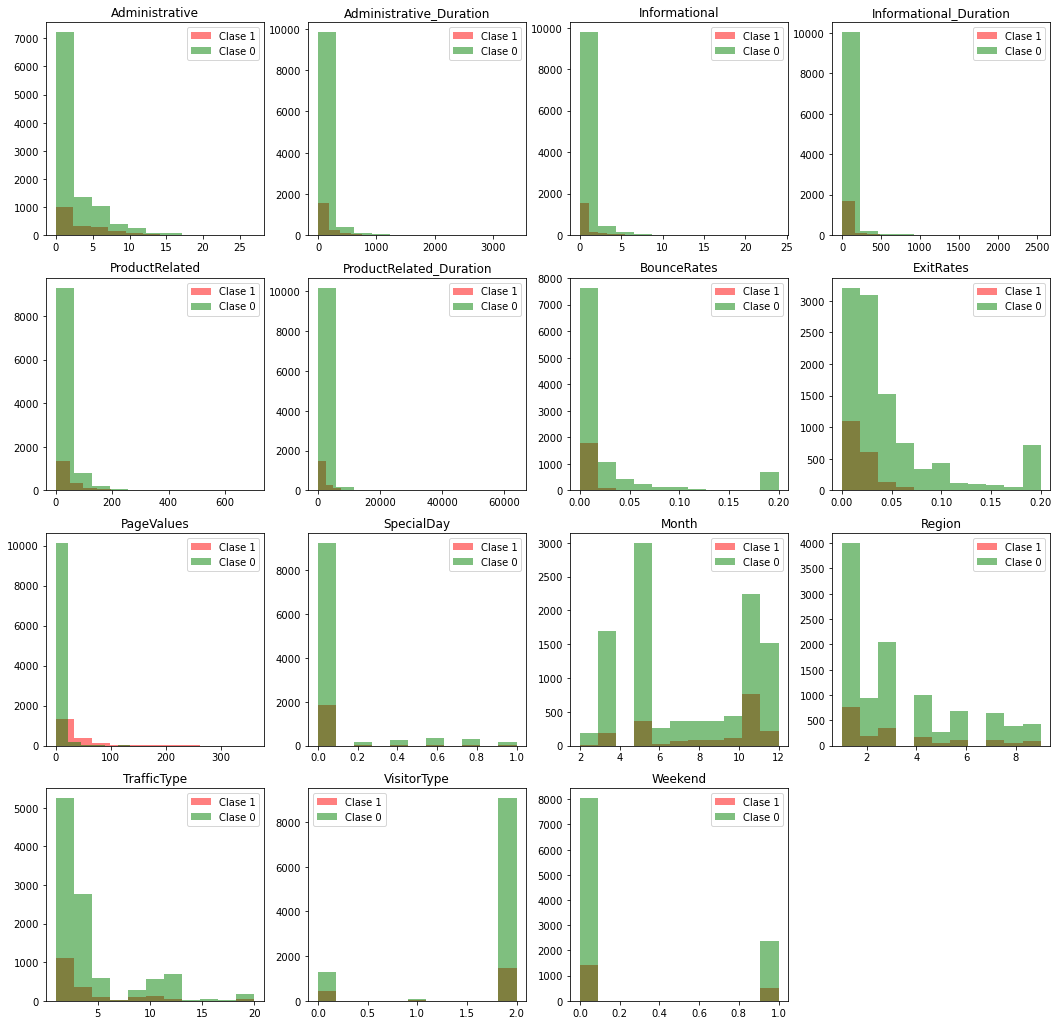

In [31]:
hist_pos_neg_feat(X,y)

    * insigth: Pagevalues seems to be the best predictor

####  2.6.2 Correlations

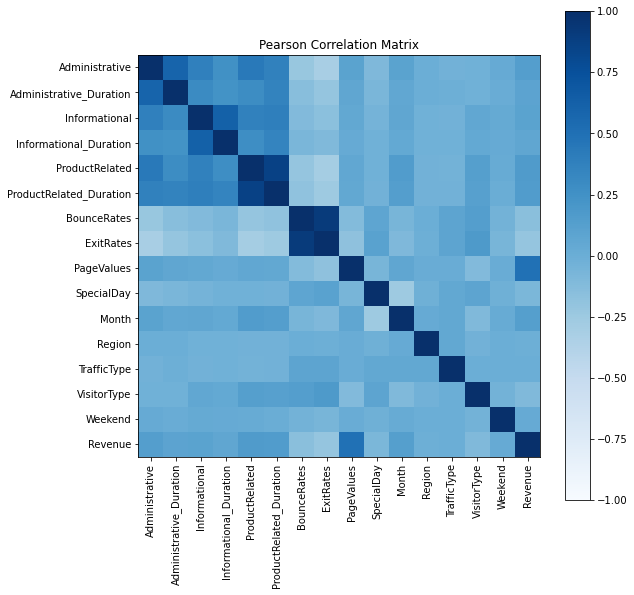

In [32]:
matriz_correlaciones = XY.corr(method='pearson')
n_ticks = len(XY.columns)
plt.figure( figsize=(9, 9) )
plt.xticks(range(n_ticks), XY.columns, rotation='vertical')
plt.yticks(range(n_ticks), XY.columns)
plt.colorbar(plt.imshow(matriz_correlaciones, interpolation='nearest', 
                            vmin=-1., vmax=1., 
                            cmap=plt.get_cmap('Blues')))
_ = plt.title('Pearson Correlation Matrix')

In [33]:
#plt.figure( figsize=(6, 6))
#plt.title('Matriz de correlaciones de Pearson')
#sns.heatmap(XY.corr(), cmap='Blues')

    * insigth:  PageValue quite clear, and  ExitRate and BOunce RAtes could be, LEt´s see the numbers:

In [34]:
corr_matrix=XY.corr()
corr_matrix['Revenue'].sort_values(ascending=False)

Revenue                    1.000000
PageValues                 0.492494
ProductRelated             0.158280
ProductRelated_Duration    0.152130
Administrative             0.138631
Month                      0.126868
Informational              0.095085
Administrative_Duration    0.093395
Informational_Duration     0.070250
Weekend                    0.029293
TrafficType               -0.005212
Region                    -0.011717
SpecialDay                -0.082468
VisitorType               -0.104548
BounceRates               -0.150621
ExitRates                 -0.206886
Name: Revenue, dtype: float64

insight:  PAgevalues has a 0,5 and then  ExitValues with a -0.2. It seems there is no a great correlation. Perhaps with a Non lineal model would be better??. Let´s see afterwards

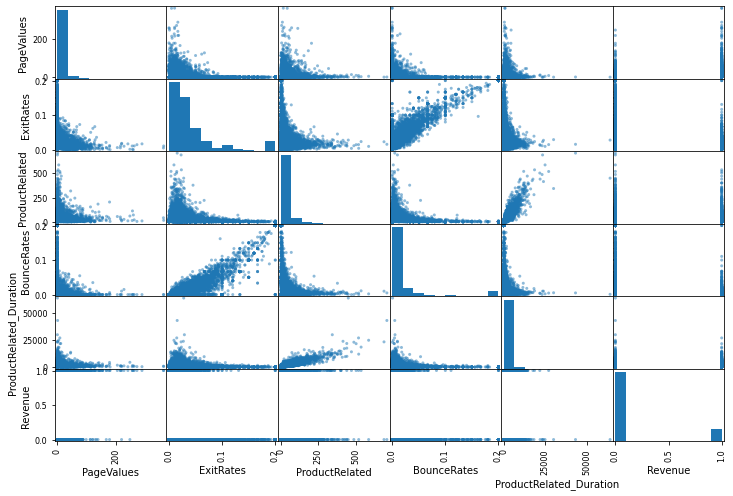

In [35]:
from pandas.plotting import scatter_matrix
scatter_matrix(XY[['PageValues','ExitRates','ProductRelated','BounceRates','ProductRelated_Duration','Revenue']], figsize=(12, 8))
plt.show()

* insigth: atention, there could be some  multicolinealitym and this could be a barrier for fitting hyperparameters.If so, VIF would be recomended (VIF 'from statsmodels.stats.outliers_influence import variance_inflation_factor')

## 3. Preprocessing for modeling
### 3.1 Scalararization. Using  RobustScaler, though  StandardScaler ( 'with_mean=False') would be also possible. 

In [36]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_scaled=scaler.fit_transform(X)

### 3.2 PCA Dimension Reduction 


In [37]:
pca = PCA(n_components = 4)
X_pca = pca.fit_transform(X_scaled)

In [38]:
pca.explained_variance_ratio_.sum() 

0.9995088295190157

In [39]:
pca.explained_variance_ratio_ 


array([9.81706326e-01, 1.70775085e-02, 5.07968888e-04, 2.17025859e-04])

* There are 2 components that hardly contribute to the variance, therefore I would choos only 2 componentes: 

In [40]:
pca_2 = PCA(n_components = 2)
X_pca_2 = pca_2.fit_transform(X_scaled)

In [41]:
pca_2.explained_variance_ratio_

array([0.98170633, 0.01707751])

In [42]:
pca_2.explained_variance_ratio_.sum()

0.9987838347715563

* the total sum fo the two variance is almost 1, so I select them for modeling

### 3.3   Train & Test Set creation

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_pca_2, y, test_size=0.2, random_state=0)

In [44]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9852, 2) (2464, 2) (9852,) (2464,)


## 4. Trainign the models

### 4.1. Logistic Regression

In [45]:
lr=LogisticRegression(max_iter=1000, penalty='l2') #penalty l2 regularized for avoiding overfitting
parametros = {"C": [0.001,0.003,0.005,0.007, 0.01, 0.02,0.04,0.07], 
              "class_weight":['balanced', None]} # due to the imbalance target vaiable

# fine tuning.
lr_gs= GridSearchCV(lr, param_grid=parametros,cv = 5, scoring='roc_auc') # scoring roc_auc

In [46]:
# fit the model 
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.04,
                               0.07],
                         'class_weight': ['balanced', None]},
             scoring='roc_auc')

In [47]:
lr_gs.best_estimator_

LogisticRegression(C=0.07, max_iter=1000)

In [48]:
print(' ROC_AUC Logistic Regresion Model: {}'.format(round(lr_gs.best_score_,4)))

 ROC_AUC Logistic Regresion Model: 0.8934


In [49]:
# LR model hyperparameters chosen
lr_def=LogisticRegression(C=0.04, class_weight='balanced', max_iter=1000)
lr_def.fit(X_train,y_train)

LogisticRegression(C=0.04, class_weight='balanced', max_iter=1000)

* Checking overfitting/underfitting

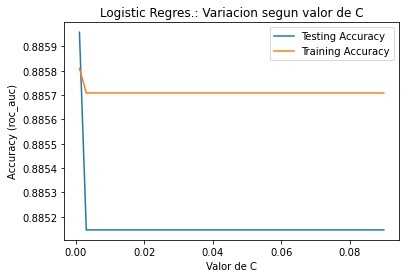

In [50]:
# Validation curve for diffente C Values

# Setup arrays to store train and test accuracies
C_value = [0.001,0.003,0.005,0.007, 0.01, 0.02,0.04,0.07,0.09]
train_accuracy = np.empty(len(C_value))
test_accuracy = np.empty(len(C_value))

# Loop over different values of C
for i, C in enumerate(C_value):
    # Setup a logistic Regression con C 
    lr_g=LogisticRegression(C=C, class_weight='balanced', max_iter=1000)

    # Fit the classifier to the training data
    lr_g.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = lr_g.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = lr_g.score(X_test, y_test)

# Generate plot
plt.title('Logistic Regres.: Variacion segun valor de C')
plt.plot(C_value, test_accuracy, label = 'Testing Accuracy')
plt.plot(C_value, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Valor de C')
plt.ylabel('Accuracy (roc_auc)')
plt.show()


insigth: Stable variance for C<0.005. However, the BIAS is a bit high, therefore it is a bit underfited

#### Model Validation 

* Predicción  for class==1 [RevRevenue=True]

In [51]:
y_pred_lr=lr_def.predict(X_test)
y_pred_prob_lr=lr_def.predict_proba(X_test) 

preds_lr=y_pred_prob_lr[:,1] 

* Metrics

La AUC de la ROC es de: 0.799
La F1 es de: 0.64

Accuracy	0.885
Sensitividad	0.676
Precisión	0.612


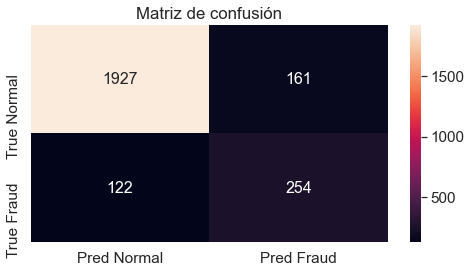

In [52]:
reporting_modelo(y_test,y_pred_lr) 

*  ROC-Curve

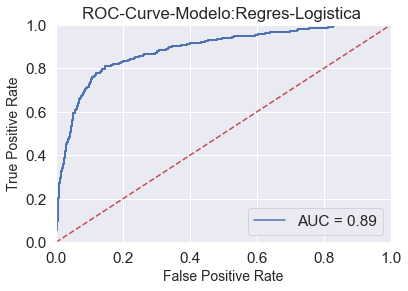

<Figure size 360x288 with 0 Axes>

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, preds_lr) 
roc_auc =auc(fpr, tpr)   
name_modelo='Regres-Logistica'
plot_roc_curve(fpr, tpr,roc_auc, name_modelo)


### 4.2 Non-Lineal KNN Classification Model

In [54]:
# model selection
knclf= KNeighborsClassifier(n_jobs=-1) 

    - For 'K' Selection, I compare the values for the  training-set and test-set avoiding overfitting and underfitting

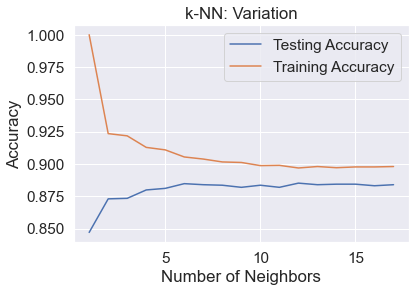

In [56]:


# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 18)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k,n_jobs=-1)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Variation' )
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()


    insigth: An optimal value seem to be between 10 and 16.I calcule it with GridSearchCV:

In [57]:
params={'n_neighbors':range(1,16)} 
knclf_gs=GridSearchCV(knclf,params,cv=4) 
knclf_gs.fit(X_train,y_train) #fitting

GridSearchCV(cv=4, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid={'n_neighbors': range(1, 16)})

In [58]:
print ('The best estimator is: {}'.format(knclf_gs.best_estimator_))

The best estimator is: KNeighborsClassifier(n_jobs=-1, n_neighbors=15)


* Definitive KNN Model. Metrics calculation:

In [59]:
# modelo final KNN
knn_def=KNeighborsClassifier(n_jobs=-1,n_neighbors=14)
knn_def.fit(X_train,y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=14)

In [60]:
# predictions for Y test
y_pred_knn=knn_def.predict(X_test) # y prediction 
y_pred_prob_knn=knn_def.predict_proba(X_test) # Probability of y prediction 
preds_knn=y_pred_prob_knn[:,1] #  class==1 selection

La AUC de la ROC es de: 0.716
La F1 es de: 0.56

Accuracy	0.884
Sensitividad	0.473
Precisión	0.672


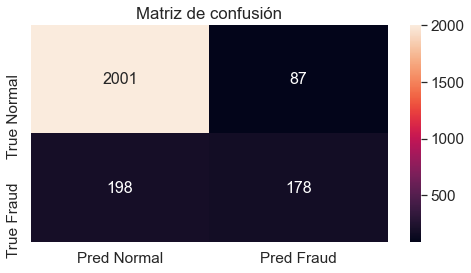

In [61]:
# metrics
reporting_modelo(y_test,y_pred_knn) # confussin matrix for thresholds=0.5


* insight: sAUC and f1 comparing with logistic regression

### 4.3 Non  lineal SVC Classification Model


In [62]:

svc=SVC(kernel='rbf',probability=True)
params={'gamma':[0.5,1,1.5,2,3,4], 'C':[0.001,0.003,0.005,0.007, 0.01, 0.02,0.04,0.07,0.09]}
svc_gs=GridSearchCV(svc,param_grid=params, cv=3,n_jobs=-1)


In [63]:
svc_gs.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.001, 0.003, 0.005, 0.007, 0.01, 0.02, 0.04,
                               0.07, 0.09],
                         'gamma': [0.5, 1, 1.5, 2, 3, 4]})

In [64]:
svc_gs.best_estimator_

SVC(C=0.09, gamma=0.5, probability=True)

In [65]:
svc_def=SVC(kernel='rbf', C=0.09,gamma=0.5,probability=True) 

In [66]:
svc_def.fit(X_train,y_train)

SVC(C=0.09, gamma=0.5, probability=True)

La AUC de la ROC es de: 0.64
La F1 es de: 0.42

Accuracy	0.87
Sensitividad	0.309
Precisión	0.659


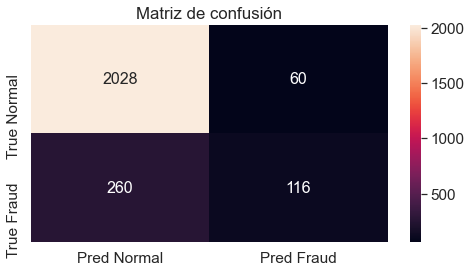

In [67]:
y_pred_svc=svc_def.predict(X_test)
y_pred_prob_svc=svc_def.predict_proba(X_test)
 
reporting_modelo(y_test,y_pred_svc)

insight: NOt really improved versus KNN

### 4.4 Neural Networks using SciKlearn

In [68]:
mlpc = MLPClassifier()
parametros = {'solver': ['lbfgs'], 
 
              'max_iter': [7000,8000,9000], # MAx Iteraciones 
              'alpha': 10.0 ** -np.arange(1, 3), #  Regularizationn L2 avoiding overfitting
              'hidden_layer_sizes':np.arange(30, 35), # Number  neurons en each layer
              'random_state':[0]}

In [69]:
mlpc_gs = GridSearchCV(mlpc, param_grid=parametros, cv = 3, 
                         scoring='roc_auc', n_jobs=-1, verbose=10)

In [70]:
mlpc_gs.fit(X_train, y_train) # fit the model

Fitting 3 folds for each of 30 candidates, totalling 90 fits


GridSearchCV(cv=3, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'alpha': array([0.1 , 0.01]),
                         'hidden_layer_sizes': array([30, 31, 32, 33, 34]),
                         'max_iter': [7000, 8000, 9000], 'random_state': [0],
                         'solver': ['lbfgs']},
             scoring='roc_auc', verbose=10)

In [71]:
mlpc_gs.best_params_ # best hyperparametros

{'alpha': 0.1,
 'hidden_layer_sizes': 32,
 'max_iter': 7000,
 'random_state': 0,
 'solver': 'lbfgs'}

In [72]:
mlpc_def= MLPClassifier(**mlpc_gs.best_params_, verbose=10) # definitive model
mlpc_def.fit(X_train, y_train) # fitting

MLPClassifier(alpha=0.1, hidden_layer_sizes=32, max_iter=7000, random_state=0,
              solver='lbfgs', verbose=10)

In [73]:
y_pred_mlpc=mlpc_def.predict(X_test)
y_pred_prob_mlpc=mlpc_def.predict_proba(X_test)
preds_mlpc=y_pred_prob_mlpc[:,1] # selecciona segunda columnas, la de la class==1

In [74]:
preds_mlpc

array([0.03911783, 0.03981176, 0.04419117, ..., 0.03999833, 0.03906414,
       0.04037644])

La AUC de la ROC es de: 0.752
La F1 es de: 0.6

Accuracy	0.886
Sensitividad	0.559
Precisión	0.646


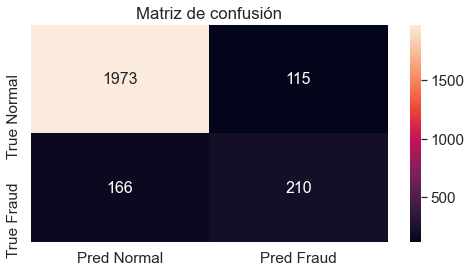

In [75]:
# metrics
reporting_modelo(y_test,y_pred_mlpc)

### 4.5 Neural Networks using  Keras/TensorFlow 

* creating the model

In [76]:
model=keras.models.Sequential()
# layer #1
model.add(keras.layers.Dense(30,activation="relu",input_dim=X_train.shape[1])) 
# layer 2
model.add(keras.layers.Dense(30,activation="relu"))
#output layer
model.add(keras.layers.Dense(1,activation="sigmoid")) 

In [77]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                90        
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
_________________________________________________________________


* compiling modelo

In [78]:

model.compile(loss="binary_crossentropy", 
              optimizer="adam",metrics=[tf.keras.metrics.AUC()])

* Fitting

In [79]:
model_history=model.fit(X_train,y_train,epochs=50 )

Epoch 1/50
308/308 [==============================] - 6s 2ms/step - loss: 0.9391 - auc: 0.5967
Epoch 2/50
308/308 [==============================] - 1s 2ms/step - loss: 0.4678 - auc: 0.8235
Epoch 3/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3512 - auc: 0.8340
Epoch 4/50
308/308 [==============================] - 1s 2ms/step - loss: 0.4035 - auc: 0.8282
Epoch 5/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3317 - auc: 0.8348
Epoch 6/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3530 - auc: 0.8335
Epoch 7/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3354 - auc: 0.8396
Epoch 8/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3311 - auc: 0.8437
Epoch 9/50
308/308 [==============================] - 1s 2ms/step - loss: 0.4404 - auc: 0.8215
Epoch 10/50
308/308 [==============================] - 1s 2ms/step - loss: 0.3228 - auc: 0.8312
Epoch 11/50
308/308 [============================

In [80]:
model_history.params

{'verbose': 1, 'epochs': 50, 'steps': 308}

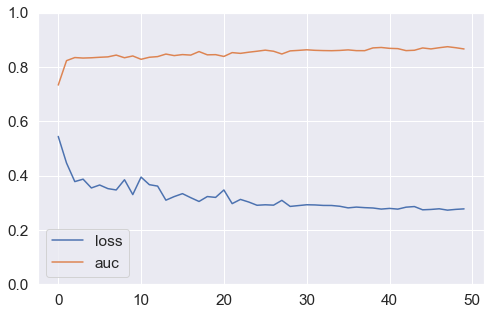

In [81]:
pd.DataFrame(model.history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show() # loss= training loss, and accuracy=training accuracy

insight: both curves are stable, therefore the model does not require more Epochs. I evaluate it:

* Performance 

In [82]:
model.evaluate(X_test,y_test)

77/77 [==============================] - 1s 2ms/step - loss: 0.2994 - auc: 0.8770


[0.2993960976600647, 0.8770023584365845]

* Predictions

In [83]:
y_pred_keras=model.predict(X_test) 

In [84]:
y_pred_keras

array([[0.0534769 ],
       [0.05510223],
       [0.05102909],
       ...,
       [0.05554113],
       [0.05333298],
       [0.05638787]], dtype=float32)

(array([1861.,   37.,   26.,   36.,   51.,  101.,  134.,  108.,   61.,
          49.]),
 array([0.04344448, 0.13870391, 0.23396334, 0.32922277, 0.4244822 ,
        0.51974165, 0.6150011 , 0.7102605 , 0.80551994, 0.90077937,
        0.9960388 ], dtype=float32),
 <BarContainer object of 10 artists>)

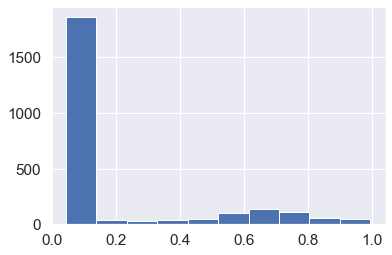

In [85]:
plt.hist(y_pred_keras)

In [86]:
# Binarizing this probability to calculate the confussion matrix
trhold=0.5
binar=Binarizer(threshold=trhold) 
y_pred_keras_thr = binar.fit_transform(y_pred_keras) 

In [87]:
y_pred_keras_thr

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

La AUC de la ROC es de: 0.81
La F1 es de: 0.64

Accuracy	0.876
Sensitividad	0.715
Precisión	0.576


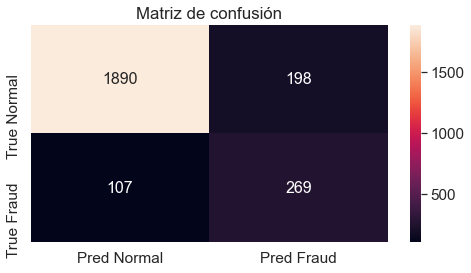

In [88]:
reporting_modelo(y_test,y_pred_keras_thr) 

## 5. BEST MODel SELECTION, based on ROCs

* No considering SVC and Neural Networks_Keras_sequentials

In [89]:
modelo=[lr_def,knn_def,mlpc_def]
score_model=np.empty(len(modelo))

for i,mod in enumerate(modelo):
    score_model[i]=cross_val_score(mod, X_train, y_train, cv=3, scoring="roc_auc").mean()

In [90]:
np.round(score_model,3)

array([0.893, 0.872, 0.895])

* NN- MLPClasiffier has a better logistic regression.
* KNN model has  the worst behavior
* Curves Visualization:

In [91]:
# obtaining values for visualizing
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, preds_lr)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, preds_knn)
fpr_svc, tpr_svc, thresholds_svc = roc_curve(y_test, y_pred_prob_svc[:,1])
fpr_mlpc, tpr_mlpc, thresholds_mlpc = roc_curve(y_test, preds_mlpc)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)


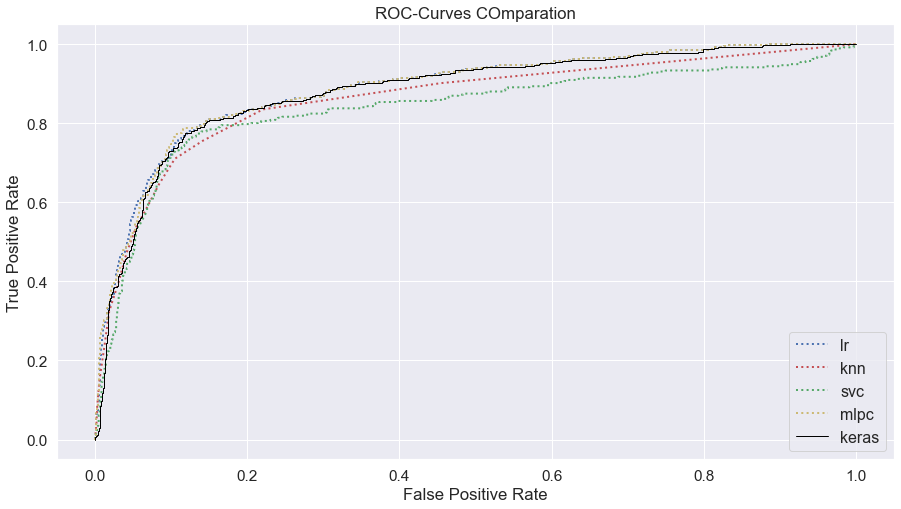

In [92]:

plt.figure(figsize=(15,8))
plt.plot(fpr_lr, tpr_lr, "b:", linewidth=2, label="lr")
plt.plot(fpr_knn, tpr_knn, "r:", linewidth=2, label="knn")
plt.plot(fpr_svc, tpr_svc, "g:", linewidth=2, label="svc")
plt.plot(fpr_mlpc, tpr_mlpc, "y:", linewidth=2, label="mlpc")
plt.plot(fpr_keras, tpr_keras, color="black", linewidth=1, label="keras")
#plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curves COmparation')
plt.legend(loc="lower right", fontsize=16)

plt.show()

## 6.  Thresholds selection for maximizing AUC

* Using NN-MLPClassifier model

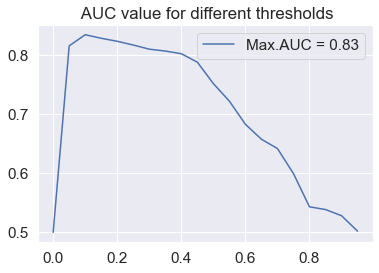

In [93]:
t=np.arange(0,1,0.05)
auc_mlpc=np.zeros(len(t))
for i,c in enumerate(t):
    binar=Binarizer(threshold=c)  
    y_pred_mlpc_thr = binar.fit_transform(y_pred_prob_mlpc)[:,1] 
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_mlpc_thr)
    auc_mlpc[i]=auc(fpr,tpr)

plt.plot(t, auc_mlpc, label='Max.AUC = %0.2f' % auc_mlpc.max())
plt.title(' AUC value for different thresholds')
plt.legend()
plt.show()
    

In [94]:
print('Threshold for max-AUC:{}'.format(t[np.where(max(auc_mlpc)==auc_mlpc)]))

Threshold for max-AUC:[0.1]


## 7.- Update metric for maximizing AUC

In [95]:
trhold=0.15
binar=Binarizer(threshold=trhold) 
y_pred_mlpc_thr = binar.fit_transform(y_pred_prob_mlpc)[:,1]

La AUC de la ROC es de: 0.828
La F1 es de: 0.65

Accuracy	0.875
Sensitividad	0.761
Precisión	0.569


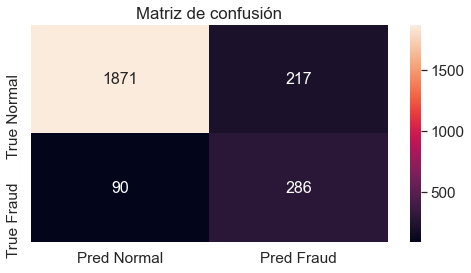

In [96]:
reporting_modelo(y_test,y_pred_mlpc_thr) 

* insight= al disminuir el threshold, se ha aumentado el AUC, a costa de disminuir la precision y aumentar la sensibilidad. 

* Vemos como quedaria la curva ROC: